In [1]:
import glob

stl_files = sorted(
    glob.glob("/home/sam/sw/chroma-lxe/data/stl/electrode_stls/5000_parts/*.stl")
)

In [2]:
import trimesh
import chroma
from chroma.io.root import RootReader

rr = RootReader("/home/sam/sw/chroma-lxe/geometry/hv.root")

pygame 2.5.2 (SDL 2.28.2, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Welcome to JupyROOT 6.22/02
Setting up ROOT datatypes.


In [3]:
import sys
sys.path.append('../geometry')

In [4]:
from geometry import build_detector_from_yaml

g = build_detector_from_yaml('../geometry/config/ea-hv.yaml')

/home/sam/sw/chroma/chroma/geometry.py:239: RuntimeWarning: overflow encountered in cast
  self.__dict__[name] = np.array(list(zip(wavelengths, value)), dtype=np.float32)
INFO:geometry:loading geometry from cache


In [5]:
ev = next(rr)

In [6]:
import numpy as np


nchannels = g.num_channels()
sum_hit = np.zeros(nchannels, dtype=np.float64)
sum_q = np.zeros(nchannels, dtype=np.float64)
nevents = len(rr)

for i,ev in enumerate(rr):
    sum_q[ev.channels.hit] += ev.channels.q[ev.channels.hit]
    sum_hit += ev.channels.hit
    
sum_q = sum_q / np.clip(sum_hit, 1, None)

In [7]:
sum_q[np.isnan(sum_q)] = 0

In [23]:
import matplotlib.cm as cm
from tqdm import tqdm
from matplotlib.colors import LogNorm

map = cm.viridis
ax = (sum_q - float(sum_q.min())) / (float(sum_q.max()) - float(sum_q.min()))
ax_log = LogNorm()(ax)
# ax_log = np.log(ax + 1e-4)

frgba = (map(ax_log) * 255).astype(int)


total_mesh = []
for i, stl_file in enumerate(tqdm(stl_files)):
    mesh = trimesh.load(stl_file)
    if any(mesh.vertices[:, 2] > 339.74896132):
        continue

    mesh.visual.face_colors = frgba[i]
    total_mesh.append(mesh)

100%|██████████| 5000/5000 [00:04<00:00, 1185.36it/s]


In [9]:
hv_fiber = trimesh.load('/home/sam/sw/chroma-lxe/data/stl/EA-HV_fiber.STL')

In [ ]:
trimesh.Scene([total_mesh,hv_fiber]).show()

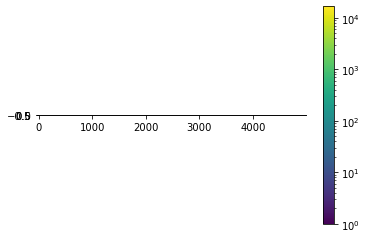

In [48]:
import matplotlib.pyplot as plt

# make a colorbar with the same colormap
fig, ax = plt.subplots()
cax = ax.imshow([sum_q], cmap='viridis', norm=LogNorm(vmin=sum_q.min(), vmax=sum_q.max()))
fig.colorbar(cax)
plt.show()

In [38]:
np.log10(sum_q.max())

4.221943415495205